# Create dataset
***

**_Autor:_** Chus Casado Rodríguez<br>
**_Fecha:_** 09-04-2024<br>

**Introduction:**<br>
This notebook creates the files that make up the ResOpsES dataset.

**To do:**<br>
* [x] Fix `point_polygon_statistics` to work with masks rasters instead of polygons, so that we can compute the attributes of reservoirs and lakes. <font color='steelblue'>I've done it using again `mask_statistics` but I needed to create a xr.DataArray of reservoir storage.
* [x] Would it be possible to use the new `lisflood-utilities.catchstats.catchment_statistics` function instead of `mask_statistics`?
* [x] In the [LISFLOOD parameters](#LISFLOOD-parameters), it could be interesting to extract the reservoir parameters for each of the reservoirs represented in EFAS. <font color='steelblue'> I have extracted for every reservoirs the calibrated reservoir parameters in their pixel</font>
* [x] There's 1 day lag between EFAS5 and EMO1. EMO1 starts January 2nd 1990, whereas EFAS5 January 1st. </font color='steelblue'>I substracted 30 hours from the original timestamp. For instance, the first timestamp is 1990-01-02 06:00 and refers to the period 1990-01-01 06:00 to 1990-01-02 06:00. By substracting 30 hours the timestamp becomes the start of the timestep and I have shifted 6 hours extra (approximation) to match the daily timestamps of the other data sources</font>
* [ ] The reservoir and lake attributes are at the moment computed from LISFLOOD maps, whereas in the case of reservoirs should be computed from the reservoirs included in the ResOpsES dataset.
* [x] Reservoir CEDEX=8012 has no data in the Hydro DB, even thouth it does have data in _Anuario de Aforos_. The reason is that the time series finishes before 1990.

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
# import rioxarray
import geopandas as gpd
from shapely.geometry import mapping
from rasterio.features import shapes
from typing import Union, List, Dict, Optional, Tuple
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime

from utils import plot_attributes

In [2]:
import sys
sys.path.append('../../../lisflood-utilities/src')
from lisfloodutilities.catchstats import catchment_statistics

## Configuration

In [3]:
PATH_DATASETS = Path('Z:/nahaUsers/casadje/datasets')

# path to the dataset ResOpsES
PATH_RESOPSES = PATH_DATASETS / 'reservoirs' / 'ResOpsES'

# path to EFASv5
PATH_EFAS = Path('E:/casadje/Documents/EFASv5/iberia')

# paths to observed time series
PATH_HDMS = PATH_DATASETS / 'hDMS' / 'reservoirs'
PATH_HIDROSUR = PATH_DATASETS / 'Hidrosur' / 'processed' / 'reservoirs'
PATH_ACA = PATH_DATASETS / 'ACA' / 'processed' / 'reservoirs'

# minimum length of observed time series (years)
MIN_YEARS = 8

## Selection of resevoirs

### Reservoirs

305 reservoirs and 10 attributes

filling key reservoir attributes
CEDEX	CAP_MCM  	298 reservoirs added
CEDEX	AREA_SKM 	297 reservoirs added
ICOLD	CAP_MCM  	6 reservoirs added
ICOLD	AREA_SKM 	7 reservoirs added

Reservoir attributes missing:
CAP_MCM     1
AREA_SKM    1
dtype: int64

304 reservoirs and 10 attributes


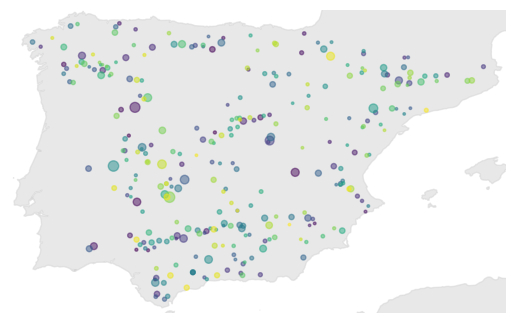

In [4]:
# load reservoir points
reservoirs = gpd.read_file(PATH_RESOPSES / 'GIS' / 'reservoirs_ResOpsES.shp')
reservoirs[['LAT', 'LON', 'CAP_MCM', 'CATCH_SKM']] = reservoirs[['LAT', 'LON', 'CAP_MCM', 'CATCH_SKM']].astype(float)
reservoirs['SNCZI'] = reservoirs['SNCZI'].astype(int)
reservoirs.set_index('SNCZI', inplace=True)

print('{0} reservoirs and {1} attributes'.format(*reservoirs.shape))

# fill in key attributes
key_attributes = ['CAP_MCM', 'AREA_SKM']
reservoirs[key_attributes] = np.nan
sources = ['CEDEX', 'ICOLD', 'GRanD']
attributes = {source: pd.read_csv(PATH_RESOPSES / 'attributes' / f'attributes_{source}.csv', index_col='SNCZI')[key_attributes] for source in sources}
print('\nfilling key reservoir attributes')
for source, df in attributes.items():
    for col in df.columns:
        # select reservoirs with missing data
        idx = df.index.intersection(reservoirs.loc[reservoirs[col].isnull()].index)
        df_ = df.loc[idx]
        # remove reservoirs in that soure missing data
        mask = df_[col].isnull()
        df__ = df_.loc[~mask]
        # attribute values
        if df__.shape[0] > 0:
            print(f'{source}\t{col:9}\t{df__.shape[0]} reservoirs added')
            reservoirs.loc[df__.index, col] = df__

print('\nReservoir attributes missing:')
mask = reservoirs[key_attributes].isnull()
print(mask.sum())
reservoirs = reservoirs.loc[~mask.any(axis=1)]

print('\n{0} reservoirs and {1} attributes'.format(*reservoirs.shape))

# plot reservoir locations
fig, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m', edgecolor='face', facecolor='lightgray'),
               alpha=.5,
               zorder=0)
reservoirs.plot(markersize=reservoirs.CAP_MCM**.5, cmap='viridis', c=reservoirs.CATCH_SKM, alpha=.5, ax=ax)
ax.set_aspect('equal')
ax.axis('off');
plt.savefig('map_selected_reservoirs.jpg', dpi=300, bbox_inches='tight');

###  Catchments

In [5]:
path = PATH_RESOPSES / 'ancillary' / 'cutmaps'
mask_map = 'upArea_01min.nc'

masks = {}
CATCH_SKM = {}
directories = [dir for dir in path.iterdir() if dir.is_dir()]
for directory in tqdm(directories, desc='loading masks'):
    try:
        # reservoir ID
        ID = int(directory.stem)
        
        # load upstream area map
        mask = xr.open_dataset(directory / mask_map)['Band1']
        mask.name = str(ID)
        CATCH_SKM[ID] = mask.max().data
        
        # create and save a mask out of the previous map
        mask = xr.where(mask.notnull(), 1, mask)
        masks[ID] = mask
    except:
        print(directory)
        continue
        
# series of catchment area in km²
CATCH_SKM = pd.Series(CATCH_SKM, name='CATCH_SKM')
CATCH_SKM /= 1e6
idx = CATCH_SKM.index.intersection(reservoirs.index)
reservoirs.loc[idx, 'CATCH_SKM'] = CATCH_SKM.loc[idx]

# export masks as NetCDF with ID as filename to be used with `catchstats`
path_masks = PATH_RESOPSES / 'ancillary' / 'cutmaps' / 'masks'
path_masks.mkdir(parents=True, exist_ok=True)
for ID, mask in masks.items():
    file_out = path_masks / f'{ID:04}.nc'
    if not file_out.exists():
        mask.to_netcdf(file_out)

loading masks:   0%|          | 0/307 [00:00<?, ?it/s]

C:\DEV\Anaconda3\envs\res\lib\site-packages\xarray\backends\plugins.py:65: RuntimeWarning: Engine 'rasterio' loading failed:
cannot import name 'NDArray' from 'numpy.typing' (C:\DEV\Anaconda3\envs\res\lib\site-packages\numpy\typing\__init__.py)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


Z:\nahaUsers\casadje\datasets\reservoirs\ResOpsES\ancillary\cutmaps\input
Z:\nahaUsers\casadje\datasets\reservoirs\ResOpsES\ancillary\cutmaps\masks


## Static maps

In this section I will compute catchment statistics of the LISFLOOD static maps that will be in the end exported as _attributes_EFAS_static_maps.csv_. As ancillary maps, I will load first the pixel area and upstream area maps, that will be needed in the subsequent calculations.

In [6]:
# load the pixel area map
pixarea = xr.open_mfdataset(f'{PATH_EFAS}/maps/pixarea*.nc')['Band1'].compute()

# load the upstream area map
upArea = xr.open_mfdataset(f'{PATH_EFAS}/maps/upArea*.nc')['Band1'].compute()

### Geomorphology

Here I will compute catchment statistics for geomorphological attributes

Time elapsed: 25.09 seconds


KeyError: '[623] not in index'

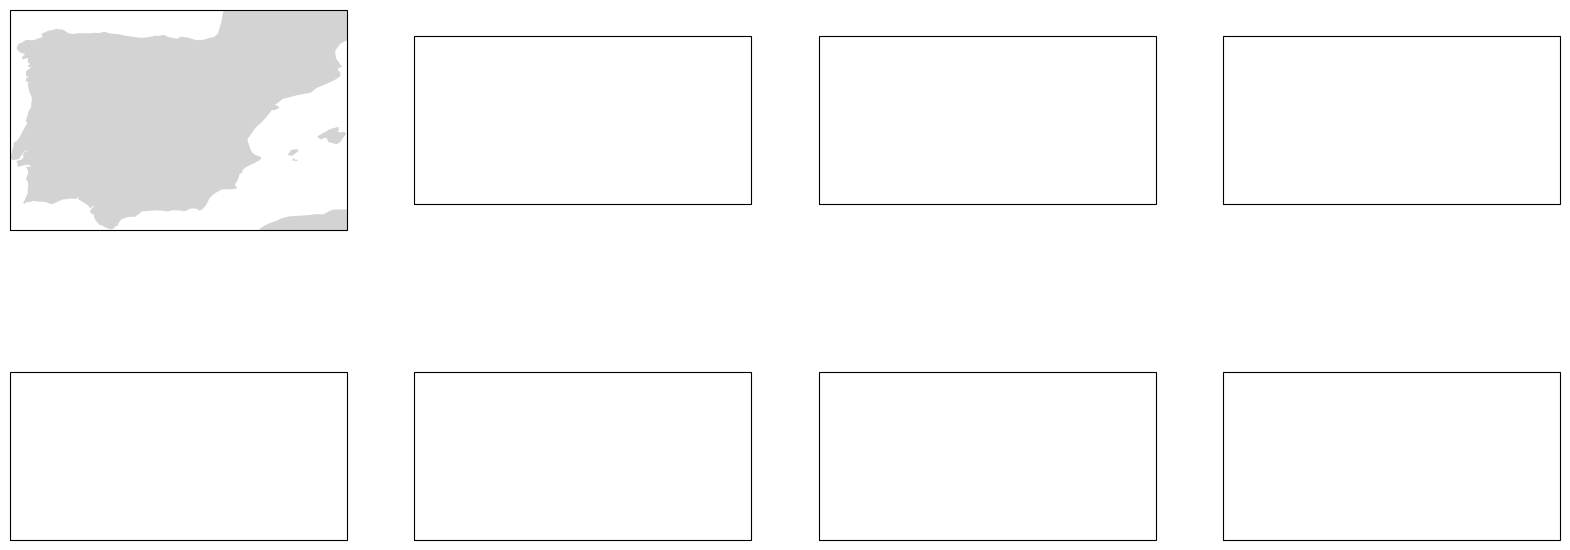

In [7]:
func = {'elv': ['mean', 'std', 'min', 'max'],
        'gradient': ['mean', 'std'],
        'upArea': ['max'],
        # 'pixarea': ['sum']
       }

# load maps
geomorphology = xr.Dataset({var: xr.open_mfdataset(f'{PATH_EFAS}/maps/{var}_*.nc')['Band1'].compute() for var in func})

# compute statistics
statistic = list(np.unique([stat for stats in func.values() for stat in stats]))
attr_geomorphology = catchment_statistics(geomorphology, masks, statistic=statistic, weight=pixarea).to_pandas()
cols = [f'{var}_{stat}' for var, stats in func.items() for stat in stats]
attr_geomorphology = attr_geomorphology[cols]
# attr_geomorphology = mask_statistics(geomorphology, masks, func, weight=pixarea).to_pandas()

# plot attributes
plot_attributes(attr_geomorphology, reservoirs.geometry.x, reservoirs.geometry.y, ncols=4)

### Land use

In [ ]:
variables = ['fracforest', 'fracirrigated', 'fracother', 'fracrice', 'fracwater', 'fracsealed']
variables.sort()

# load maps
land_use = xr.Dataset({var: xr.open_mfdataset(f'{PATH_EFAS}/maps/{var}_*.nc')['Band1'].compute() for var in variables})
land_use = land_use.rename({var: var[4:] for var in list(land_use)})

# compute statistics
attr_landuse = catchment_statistics(land_use, masks, statistic=['mean'], weight=pixarea).to_pandas()
# attr_landuse = mask_statistics(land_use, masks, func='mean', weight=pixarea).to_pandas()
attr_landuse.sort_index(axis=1, inplace=True)

# compute main land use
lu_classes = {col: i for i, col in enumerate(attr_landuse.columns, start=1)}
attr_landuse['land_use_main'] = attr_landuse.idxmax(axis=1).map(lu_classes)

# rename attributes
attr_landuse.rename(columns={col: col.split('_')[0] if 'mean' in col else col for col in attr_landuse}, inplace=True)

# plot attributes
plot_attributes(attr_landuse, reservoirs.geometry.x, reservoirs.geometry.y, ncols=4)

### Crop coefficient

In [ ]:
# mapping land use acronym and name
mapping_landuse = {'f': 'forest', 'i': 'irrigated', 'o': 'other'}
variables = ['cropcoef_f', 'cropcoef_i', 'cropcoef_o']

# load maps
crops = xr.Dataset({var: xr.open_mfdataset(f'{PATH_EFAS}/maps/{var}_*.nc')['Band1'].compute() for var in variables})
crops = crops.rename({var: mapping_landuse[var.split('_')[1]] for var in list(crops)})

# mean weighted by the fraction of pixel covered by each land use
crops = crops.to_array('land_use').weighted(land_use.to_array('land_use').fillna(0)).sum('land_use', skipna=True) 
crops = crops.where(~upArea.isnull())
crops.name = 'cropcoef'

# compute statistics
attr_crops = catchment_statistics(crops, masks, statistic=['mean', 'std'], weight=pixarea).to_pandas()
# attr_crops = mask_statistics(crops, masks, func=['mean', 'std']).to_pandas()

# plot attributes
plot_attributes(attr_crops, reservoirs.geometry.x, reservoirs.geometry.y, ncols=2)

### Streams

In [ ]:
func = {'chanbnkf': ['mean'],
        'chanbw': ['mean'],
        'changrad': ['mean'],
        'chanlength': ['sum'],
        'chanman': ['mean']}

# load maps
streams = {var: xr.open_mfdataset(f'{PATH_EFAS}/maps/{var}_*.nc')['Band1'].compute() for var in func}
streams = {var: da.rename(var) for var, da in streams.items()}
streams = {var : da.drop([coord for coord in list(da.coords) if coord not in ['lon', 'lat']]) for var, da in streams.items()}
streams = xr.Dataset({var: xr.DataArray(da.data, coords=upArea.coords, name=var) for var, da in streams.items()})

# mask streams (pixels with depth larger than 1 m)
rivers = streams['chanbnkf'] > 1
# rivers.plot(cmap='Blues')
streams = streams.where(rivers)

# calcular estadístico
# attr_streams = mask_statistics(streams, masks, func).to_pandas()
statistic = list(np.unique([stat for stats in func.values() for stat in stats]))
attr_streams = catchment_statistics(streams, masks, statistic, weight=pixarea).to_pandas()
cols = [f'{var}_{stat}' for var, stats in func.items() for stat in stats]
attr_streams = attr_streams[cols]

# plot attributes
plot_attributes(attr_streams, reservoirs.geometry.x, reservoirs.geometry.y, ncols=5)

### Soil properties

In [ ]:
variables = ['ksat', 'lambda', 'genua', 'soildepth', 'thetas', 'thetar']
layers = [1, 2, 3]
maps = [f'{var}{layer}' for var in variables for layer in layers]

# load maps
soils = {}
for var in tqdm(maps, desc='loading maps'):
    files = list((PATH_EFAS / 'maps').glob(f'{var}_*.nc'))
    if len(files) > 1:
        ds = {}
        for file in files:
            # type of land use
            cover = mapping_landuse[file.stem.split('_')[1]]
            # import map
            ds[cover] = xr.open_dataset(file)['Band1']
        ds = xr.Dataset(ds)
        da = ds.to_array('land_use').weighted(land_use.to_array('land_use').fillna(0)).sum('land_use', skipna=True)
        soils[var] = da.where(~upArea.isnull())
    elif len(files) == 1:
        soils[var] = xr.open_dataset(files[0])['Band1']
soils = xr.Dataset(soils)

# compute statistics
# attr_soils = mask_statistics(soils, masks, func='mean').to_pandas()
attr_soils = catchment_statistics(soils, masks, statistic=['mean'], weight=pixarea).to_pandas()

# rename attributes
attr_soils.rename(columns={col: col.split('_')[0] for col in attr_soils if 'mean' in col}, inplace=True)

# plot attributes
plot_attributes(attr_soils, reservoirs.geometry.x, reservoirs.geometry.y, ncols=6)

### LAI

I convert the timeseries of 10-daily timesteps into annual averages.

In [ ]:
maps = ['laif', 'laii', 'laio']

# load maps
lai = xr.Dataset({var: xr.open_mfdataset(f'{PATH_EFAS}/maps/{var}_*.nc')['Band1'].compute() for var in maps})
lai = lai.rename({var: mapping_landuse[var[3]] for var in list(lai)})

# mean wheighted by the portion of pixel covered by each land use
lai = lai.to_array('land_use').weighted(land_use.to_array('land_use').fillna(0)).sum('land_use', skipna=True) 
lai = lai.where(~upArea.isnull())
lai.name = 'lai'
lai['time'] = pd.date_range('2021-01-05', periods=len(lai.time), freq='10D')

# monthly resampling
lai_m = lai.resample(time='1M').mean()
lai_m['time'] = [f'{i:02}' for i in range(1, 13)]
lai_agg = xr.Dataset({f'lai{month}': lai_m.sel(time=month).drop('time') for month in lai_m.time.data})

# annual statistics
lai_agg['laiyrmean'] = lai.mean('time')
lai_agg['laiyrmax'] = lai.max('time')
lai_agg['laiyrmin'] = lai.min('time')

# compute statistics
# attr_lai = mask_statistics(lai_agg, masks, func=['mean']).to_pandas()
attr_lai = catchment_statistics(lai_agg, masks, statistic=['mean'], weight=pixarea).to_pandas()

# rename attributes
attr_lai.rename(columns={col: '_'.join(col.split('_')[:-1]) for col in attr_lai if 'mean' in col}, inplace=True)

# plot attributes
plot_attributes(attr_lai, reservoirs.geometry.x, reservoirs.geometry.y, ncols=5)

### Water demand

The original demand maps are monthly time series (domestic, energy, industry, livestock) in mm/day for the period 1990-2023. 

I will compute annual and monthly averages and from those I will compute statistics.

In [ ]:
maps = ['dom', 'ene', 'ind', 'liv']

# load maps
demand = xr.Dataset({var: xr.open_mfdataset(f'{PATH_EFAS}/maps/{var}_*.nc')[var].compute() for var in maps})

# monthly means
demand_m = demand.groupby('time.month').mean('time')

# annual mean
demand_y = demand.groupby('time.year').mean('time').mean('year')
# demand_y = demand.mean('time')

# combine in a single dataset
demand_agg = xr.Dataset()
for key, da in demand_m.items():
    for month in da.month.data:
        demand_agg[f'{key}_{month:02}'] = da.sel(month=month).drop('month')
    demand_agg[f'{key}_yr'] = demand_y[key]

# convert to volume
# demand_agg = demand_agg * 1e-3 * pixarea

# compute statistics
# attr_demand = mask_statistics(demand_agg, masks, func='sum').to_pandas()
attr_demand = catchment_statistics(demand_agg, masks, statistic=['sum'], weight=pixarea).to_pandas()

# rename attributes
attr_demand.rename(columns={col: '_'.join(col.split('_')[:-1]) for col in attr_demand if 'sum' in col}, inplace=True)

# plot attributes
plot_attributes(attr_demand[['dom_yr', 'ene_yr', 'ind_yr', 'liv_yr']], reservoirs.geometry.x, reservoirs.geometry.y, ncols=4)

### Reservoirs

It could be interesting to add two attributes that account for the number of reservoirs upstream and the total storage volume of those reservoirs. I can do it with the reservoirs in EFASv5, but those do not include all the reservoirs in ResOpsES (not to mention all the actual reservoirs).

In [ ]:
# load map or reservoir ID
var = 'res'
res_xr = xr.open_mfdataset(f'{PATH_EFAS}/maps/{var}_*.nc')[var].compute()

# extract reservoir ID
ids = [int(id) for id in np.unique(res_xr) if not np.isnan(id)]
print('EFAS represents {0} reservoirs in the study area'.format(len(ids)))

# load table of total reservoir storage
storage_pd = pd.read_csv(PATH_EFAS.parent / 'tables' / 'rtstor.txt', sep=' ', header=None, index_col=0).squeeze().astype('int64')
storage_pd.index.name = 'ResID'
storage_pd.name = 'storage'

# create map of reservoir storage
storage = res_xr.copy()
for id in ids:
    storage = storage.where(res_xr != id, other=storage_pd.loc[id])
# storage /= 1e6
storage.name = 'storage'
storage.attrs['units'] = 'm3'
storage.attrs['standard_name'] = 'capacity'
storage.attrs['long_name'] = 'reservoir_storage_capacity'

# compute statistics
# attr_reservoir = mask_statistics(storage, masks, func=['count', 'sum']).to_pandas()
attr_reservoir = catchment_statistics(storage, masks, statistic=['count', 'sum']).to_pandas()

# rename attributes
attr_reservoir.rename(columns={'storage_count': 'no_reservoirs', 'storage_sum': 'storage_reservoirs'}, inplace=True)

# plot attributes
plot_attributes(attr_reservoir, reservoirs.geometry.x, reservoirs.geometry.y)

### Lakes

In [ ]:
# load map or reservoir ID
var = 'lakes'
lakes_xr = xr.open_mfdataset(f'{PATH_EFAS}/maps/{var}_*.nc')[var].compute()

# extract lake ID
ids = [int(id) for id in np.unique(lakes_xr) if not np.isnan(id)]
print('EFAS represents {0} lakes in the study area'.format(len(ids)))

# load table of lake area
lakes_pd = pd.read_csv(PATH_EFAS.parent / 'tables' / 'lakearea.txt', sep=' ', header=None, index_col=0).squeeze().astype('int64')
lakes_pd.index.name = 'LakeID'
lakes_pd.name = 'area'

# create map of lake area
lakearea = lakes_xr.copy()
for id in ids:
    lakearea = lakearea.where(lakes_xr != id, other=lakes_pd.loc[id])
lakearea.name = 'area'
lakearea.attrs['units'] = 'm2'
lakearea.attrs['standard_name'] = 'area'
lakearea.attrs['long_name'] = 'lake_surface_area'

# compute statistics
# attr_lake = mask_statistics(lakearea, masks, func=['count', 'sum']).to_pandas()
attr_lake = catchment_statistics(lakearea, masks, statistic=['count', 'sum']).to_pandas()

# rename attributes
attr_lake.rename(columns={'area_count': 'no_lakes', 'area_sum': 'area_lakes'}, inplace=True)

# plot attributes
plot_attributes(attr_lake, reservoirs.geometry.x, reservoirs.geometry.y)

### Export

In [ ]:
# concatenate all attributes
attrs = pd.concat((attr_geomorphology,
                  attr_landuse,
                  attr_crops,
                  attr_streams,
                  attr_soils,
                  attr_lai,
                  attr_demand,
                  attr_reservoir,
                  attr_lake,
                 ), axis=1)
attrs.index.name = 'SNCZI'
attrs.sort_index(axis=0, inplace=True)

print('{0} attributes define the characteristics of {1} catchments'.format(*attrs.shape[::-1]))

# export
attrs.to_csv(PATH_RESOPSES / 'attributes' / 'attributes_EFAS_static_maps.csv')

## LISFLOOD parameters

In this section I load the maps of LISFLOOD calibrated parameters an compute mean catchment values. The results are exported as a CSV file named _attributes_EFAS_model_parameters.csv_.

In [ ]:
# list of calibrated parameters in LISFLOOD
pars = {file.stem: file for file in (PATH_EFAS / 'parameters').glob('*.nc') if not file.stem.lower().startswith('efas')}
print(f'{len(pars)} parameters were calibrated in EFAS')

# load parameter maps
params = xr.Dataset({par: xr.open_dataset(file)[par].compute() for par, file in pars.items()})

# plot reservoir parameters
reservoir_parameters = ['adjust_Normal_Flood', 'ReservoirRnormqMult']
fig, axes = plt.subplots(ncols=len(reservoir_parameters), figsize=(12, 4), sharex=True, sharey=True)
for ax, par in zip(axes, reservoir_parameters):
    params[par].plot(ax=ax, add_colorbar=True, cmap='magma', cbar_kwargs={'shrink': 0.66})
    ax.scatter(reservoirs.geometry.x, reservoirs.geometry.y, s=2, c='w')
    ax.set_title(par)
    ax.set_aspect('equal')
    ax.axis('off')

# extract the pixel value of reservoir parameters
points = reservoirs[['LAT', 'LON']].to_xarray()
parameters1 = params[reservoir_parameters].sel(lat=points.LAT, lon=points.LON, method='nearest').compute()
parameters1 = parameters1.to_pandas()[reservoir_parameters]

# compute catchment statistics of the other parameters
other_parameters = list(set(list(pars)).difference(reservoir_parameters))
parameters2 = catchment_statistics(params[other_parameters], masks, statistic=['mean'], weight=pixarea).to_pandas()
parameters2.index.name = 'SNCZI'
parameters2.sort_index(axis=0, inplace=True)
parameters2.rename(columns={col: '_'.join(col.split('_')[:-1]) for col in parameters if 'mean' in col}, inplace=True)

# concatenate
parameters = pd.concat((parameters1, parameters2), axis=1)

# plot parameters
plot_attributes(parameters[reservoir_parameters], reservoirs.geometry.x, reservoirs.geometry.y, ncols=5)
print('{0} LISFLOOD calibrated parameters have been averaged for {1} catchments'.format(*parameters.shape[::-1]))

# export
parameters.to_csv(PATH_RESOPSES / 'attributes' / 'attributes_EFAS_model_parameters.csv')

## Time series

In this section I used the EMO1 meteorological time series and the EFAS5 discharge reanalysis to create both hydrometeorological attributes (_attributes_EFAS_hydrometeorology.csv_) and the time series that may be used as input in the deep learning model.

### Load time series
#### Meteorology: EMO-1

**Areal time series**

In [ ]:
# load meteorological time series
path_meteo = PATH_RESOPSES / 'ancillary' / 'catchstats' / 'meteo'
variables = [x.stem for x in path_meteo.iterdir() if x.is_dir()]
meteo = xr.Dataset({f'{var}_emo1': xr.open_mfdataset(f'{path_meteo}/{var}/*.nc')[f'{var}_mean'].compute() for var in variables})
meteo['time'] = meteo['time'] - np.timedelta64(30, 'h') # WARNING!! One day lag compared with EFAS5
meteo = meteo.rename({'id': 'SNCZI'})
meteo = meteo.sel(SNCZI=reservoirs.index)

# define attributes
emo1_units = 'e0_emo1: potential evaporation from open water from EMO1 [mm/d]\npr_emo1: observed precipitation from EMO1 [mm/d]\nta_emo1: observed air temperature from EMO1 [°C]\n'
meteo.attrs['Units'] = emo1_units
meteo.time.attrs['timezone'] = 'UTC+00'
meteo.SNCZI.attrs['Description'] = 'The code that identifies a reservoir in the Spanish Inventory of Dams and Reservoirs (Sistema Nacional de Cartografía de Zonas Inundables)'

In [ ]:
# # plot the time series of a specific catchment to check the areal aggregation
# ID = 10
# fig, axes = plt.subplots(nrows=3, figsize=(12, 12), sharex=True)
# for ax, var in zip(axes, ['pr', 'ta', 'e0']):
#     meteo[var].sel(id=ID).plot(ax=ax)

**Point time series**

In [ ]:
# load meteorological time series
path_evapo = PATH_RESOPSES / 'ancillary' / 'ncextract' / 'e0'

# load evaration time series (mm/d)
evapo = xr.open_mfdataset(f'{path_evapo}/*.nc', combine='nested', concat_dim='SNCZI')['e0'].compute()
evapo = evapo.sel(SNCZI=reservoirs.index)
evapo.name = 'evaporation_emo1'

# Create a CRS variable and set its attributes
crs_attrs = {'epsg_code': 'EPSG:4326',
             'semi_major_axis': 6378137.0,  # WGS 84
             'inverse_flattening': 298.257223563,  # WGS 84
             'grid_mapping_name': 'latitude_longitude'
            }
evapo['crs'] = xr.DataArray(data=0, attrs=crs_attrs)  # CRS variable with its attributes

# define attributes
evapo.attrs['Units'] = 'evapo_emo1: open water evaporation (mm/d)\n'
evapo.time.attrs['timezone'] = 'UTC+00'
evapo.SNCZI.attrs['Description'] = 'The code that identifies a reservoir in the Spanish Inventory of Dams and Reservoirs (Sistema Nacional de Cartografía de Zonas Inundables)'
lat_attrs = {'Units': 'degrees_north',
             'standard_name': 'latitude',
             'grid_mapping': 'crs'}
lon_attrs = {'Units': 'degrees_east',
             'standard_name': 'longitude',
             'grid_mapping': 'crs'}
evapo.lat.attrs = lat_attrs
evapo.lon.attrs = lon_attrs

#### EFAS long run

In [ ]:
# load discharge time series
path_discharge = PATH_RESOPSES / 'ancillary' / 'ncextract' / 'discharge'
inflow = xr.open_mfdataset(f'{path_discharge}/*.nc', combine='nested', concat_dim='SNCZI')['dis'].compute()
inflow = inflow.sel(SNCZI=reservoirs.index)
inflow.name = 'inflow_efas5'

# # compute specific discharge
# catch_area = attr_geomorphology['upArea_max'].copy()
# catch_area.index.name = 'SNCZI'
# catch_area.name = 'CATCH_SM' # in m²
# catch_area = xr.DataArray(catch_area)
# inflow = inflow / catch_area * 3600 * 24 * 1000 # mm/d
# inflow = inflow.round(2)

# Create a CRS variable and set its attributes
inflow['crs'] = xr.DataArray(data=0, attrs=crs_attrs)  # CRS variable with its attributes

# define attributes
inflow.attrs['Units'] = 'inflow_efas5: simulated discharge from EFASv5 (m3/s)\n'#'dis_efas5: discharge reanalysis (mm/d)\n'
inflow.time.attrs['timezone'] = 'UTC+00'
inflow.SNCZI.attrs['Description'] = 'The code that identifies a reservoir in the Spanish Inventory of Dams and Reservoirs (Sistema Nacional de Cartografía de Zonas Inundables)'
inflow.lat.attrs = lat_attrs
inflow.lon.attrs = lon_attrs

#### Observation

At the model of writing, only the reservoirs from CEDEX are available in the Hydrological Data Management Service (HDMS). The data in HDMS has been quality checked and interpolated to the timezone UTC+00. The data from the Catalan (Agència Catalana del Aigua, ACA) and Andalusian (Hidrosur) agencies are not yet in HDMS, so I will use the raw data.

In [ ]:
start = inflow.time[0].data

In [ ]:
# import reservoirs in the Hydrological Data Management Service
hdms = gpd.read_file(PATH_HDMS / 'reservoirs.shp')
hdms = hdms[['EFAS_ID', 'Name', 'National_S', 'Prov_ID', 'Country-Co', 'Country']]
hdms = hdms.loc[hdms.Prov_ID == '1088']
hdms[['EFAS_ID', 'National_S', 'Prov_ID']] = hdms[['EFAS_ID', 'National_S', 'Prov_ID']].astype(int)
hdms.rename(columns={'National_S': 'LOCAL_ID'}, inplace=True)
hdms.set_index('LOCAL_ID', drop=True, inplace=True)

print('There are {0} reservoirs in HDMS'.format(hdms.shape[0]))

In [ ]:
# load observed time series
obs = {}
for ID in tqdm(reservoirs.index, desc='loading observed timeseries'):
        
    local_ID, provider = reservoirs.loc[ID, ['ID_TS', 'SOURCE_TS']]

    if provider == 'CEDEX':
        hdms_ID = hdms.loc[int(local_ID), 'EFAS_ID']
        file = PATH_HDMS / 'nhoperational24hw' / f'{hdms_ID:04}.nc'
        if file.exists():
            ds = xr.open_dataset(file).sel(ID=hdms_ID)
            ds.close()
            ds['ID'] = ID
        else:
            print(f'File {file} does not exist')
    elif provider == 'ACA':
        file = PATH_ACA / 'timeseries' / f'{local_ID}.csv'
        if file.exists():
            df = pd.read_csv(file, usecols=['date', 'level', 'volume'])
            df.date = pd.to_datetime(df.date, format='%Y-%m-%d')
            df['ID'] = ID
            df.set_index(['date', 'ID'], drop=True, inplace=True)
            ds = xr.Dataset.from_dataframe(df).sel(ID=ID)
        else:
            print(f'File {file} does not exist')
    elif provider == 'Hidrosur':
        file = PATH_HIDROSUR / 'timeseries' / f'{int(local_ID):03}.csv'
        if file.exists():
            df = pd.read_csv(file)
            df.datetime = pd.to_datetime(df.datetime)
            # select values at the beginning of each day
            df.set_index('datetime', drop=True, inplace=True)
            datemin, datemax = df.index[df.index.hour == 0][[0, -1]]
            idx = pd.date_range(datemin, datemax, freq='D')
            df = df.loc[idx]
            # convert to xarray.Dataset
            df.index.name = 'date'
            df['ID'] = ID
            df.set_index([df.index, df.ID], inplace=True)
            df.drop('ID', axis=1, inplace=True)
            ds = xr.Dataset.from_dataframe(df).sel(ID=ID)
        else:
            print(f'File {file} does not exist')
    else:
        continue
    if ds.date.data[0] < start:
        ds = ds.sel(date=slice(start, None))
    obs[ID] = ds.rename({'ID': 'SNCZI'})

### Attributes

Here I derive the attributes from the time series.

#### EMO-1

In [ ]:
# monthly aggregation (as mean daily value)
meteo_m = meteo.groupby('time.month').mean()
meteo_m = meteo_m.rename({'month': 'time'})

# annual aggregation (as mean daily value)
meteo_y = meteo.mean('time')
meteo_y['time'] = ['year']

# concatenate monthly and annual aggregations
meteo_ag = xr.concat((meteo_m, meteo_y), dim='time')

# organizar en un DataFrame
attr_climate = pd.DataFrame(index=meteo_ag.SNCZI.data)
for var, da in tqdm(meteo_ag.items()):
    # mensual
    df = da.to_pandas().transpose()
    df.columns = [f'{var}_{i:02}' if i != 'year' else f'{var}_{i}' for i in df.columns]
    # concatenar
    attr_climate = pd.concat((attr_climate, df), axis=1)
attr_climate.index.name = 'SNCZI'

In [ ]:
# box plots of monthly and annual meteorological values
ncols = len(meteo)
fig, axes = plt.subplots(ncols=ncols, figsize=(5 * ncols, 3.5))

for ax, var in zip(axes, list(meteo)):
    mask_var = attr_climate.columns.str.startswith(var)
    df = attr_climate.loc[:, mask_var]
    ax.boxplot(df)
    if var in ['pr_emo1', 'e0_emo1']:
        ax.set_ylabel('mm/d')
    elif var in ['ta_emo1']:
        ax.set_ylabel('°C')
    ax.set_title(' '.join(var.split('_')))
    ax.set_xticklabels([i for i in range(1, 13)] + ['yr'])

In [ ]:
# maps of annual meteorological averages
plot_attributes(attr_climate[['pr_emo1_year', 'ta_emo1_year', 'e0_emo1_year']],
                reservoirs.geometry.x,
                reservoirs.geometry.y)

#### EFAS long run

<font color='red'>Add standard deviation or coefficient of variation?</font>

In [ ]:
var = 'inflow_efas5'

# mean monthly discharge inflow
inflow_m = inflow.groupby('time.month').mean('time').to_pandas()
inflow_m.columns = [f'{var}_{month:02}' for month in inflow_m.columns]

# annual average on minimum, mean and maximum discharge inflow
inflow_y = inflow.groupby('time.year')
inflow_y = pd.DataFrame({f'{var}_yrmean': inflow_y.mean().mean('year').to_pandas(),
                      f'{var}_yrmax': inflow_y.max().mean('year').to_pandas(),
                      f'{var}_yrmin': inflow_y.min().mean('year').to_pandas()})
inflow_y.index.name = 'SNCZI'

# combine in a single DataFrame
attr_inflow = pd.concat((inflow_m, inflow_y), axis=1)

# plot
plot_attributes(attr_inflow[['inflow_efas5_yrmean', 'inflow_efas5_yrmax', 'inflow_efas5_yrmin']], reservoirs.geometry.x, reservoirs.geometry.y, ncols=5)

#### Export

In [ ]:
# concatenate attributes
attr_hydrology = pd.concat((attr_climate, attr_inflow), axis=1)

print('{0} attributes define the hydrometeorology of {1} catchments'.format(*attr_hydrology.shape[::-1]))

# exportar
attr_hydrology.to_csv(PATH_RESOPSES / 'attributes' / 'atributes_EFAS_hydrometeorology.csv')

### Time series

Here I generate the files in the *timeseries* subfolder of the data set that will be the forcing data in the deep learning model. When possible, I will convert the variables first to volume (m3) and second to fraction of the specific reservoir capacity. In this way, all the time series used in the reservoir routine are in the same unit (adimensional), and in addition is normalized by the size of the reservoir (values from 0 to 1).

In [ ]:
# rename variables in 'meteo' and 'inflow'
if 'time' in meteo.coords:
    meteo = meteo.rename({'time' : 'date'})
if 'time' in inflow.coords:
    inflow = inflow.rename({'time' : 'date'})
if 'time' in evapo.coords:
    evapo = evapo.rename({'time' : 'date'})

In [ ]:
area_sm = xr.DataArray.from_series(reservoirs.AREA_SKM) * 1e6 # m2
capacity_cm = xr.DataArray.from_series(reservoirs.CAP_MCM) * 1e6 # m3
catchment_sm = xr.DataArray.from_series(reservoirs.CATCH_SKM) * 1e6 # m2

#### Convert units

**Observed timeseries**

In [ ]:
obs_converted = obs.copy()
for ID, ds in obs_converted.items():
    if 'volume' in list(ds):
        ds['volume'] /= reservoirs.loc[ID, 'CAP_MCM']
    if 'outflow' in list(ds):
        ds['outflow'] *= 24 * 3600 / (reservoirs.loc[ID, 'CAP_MCM'] * 1e6)
    ds = ds.rename({'volume': 'storage'})

**Reservoir evaporation**

In [ ]:
evapo_converted = evapo * area_sm / capacity_cm
evapo_converted.name = 'e0_res_emo1'

**Simulated inflow**

In [ ]:
inflow_converted = inflow * 24 * 3600 / capacity_cm

**Catchment meteorology**

In [ ]:
# convert evaporation units to fraction filled
evapo_catch = meteo['e0_emo1'] * catchment_sm * 1e-3 / capacity_cm 

# convert evaporation units to fraction filled
precip_catch = meteo['pr_emo1'] * catchment_sm * 1e-3 / capacity_cm

meteo_converted = xr.Dataset({'evapo_areal_emo1': evapo_catch, 'precip_areal_emo1': precip_catch, 'temp_areal_emo1': meteo['ta_emo1']})

#### CSV

LIMIT THE PERIOD!!

In [ ]:
# output directory
path_ts_csv = PATH_RESOPSES / 'timeseries' / 'csv' 
path_ts_csv.mkdir(parents=True, exist_ok=True)
path_ts_nc = PATH_RESOPSES / 'timeseries' / 'netcdf' 
path_ts_nc.mkdir(parents=True, exist_ok=True)

for ID in tqdm(reservoirs.index, desc='reservoirs'):
    
    # observed storage (and outflow)
    obs_id = obs_converted[ID].drop(['SNCZI'])
    
    # simulated inflow
    efas = inflow_converted.sel(SNCZI=ID).drop(['SNCZI', 'lat', 'lon', 'crs'])
    efas.name = 'inflow_efas5'
    
    # reservoir evaporation
    emo_res = evapo_converted.sel(SNCZI=ID).drop(['SNCZI', 'lat', 'lon', 'crs'])
    emo_res.name = 'evaporation_emo1'
    
    # catchment meteorological
    emo_catch = meteo_converted.sel(SNCZI=ID).drop(['SNCZI'])

    # combine time series
    ds = xr.merge((obs_id, efas, emo_res, emo_catch))#, compat='override')    
    
    # find period with observations
    df = ds.to_pandas()
    start_id, end_id = df.volume.first_valid_index(), df.volume.last_valid_index()
    if 'outflow' in df.columns:
        start_id = max(start_id, df.outflow.first_valid_index())
        end_id = min(end_id, df.outflow.last_valid_index())
        
    if (end_id - start_id).days >= MIN_YEARS * 365:
        print(ID, start_id.date(), end_id.date(), sep='\t')
    
        # export CSV
        # ..........
        df.loc[start_id:end_id, :].to_csv(path_ts_csv / f'{ID:04}.csv')

        # export NetCDF
        # .............
        ds.sel(date=slice(start_id, end_id)).to_netcdf(path_ts_nc / f'{ID:04}.nc')
    else:
        print(ID, start_id.date(), end_id.date(), f'Observed period shorter than {MIN_YEARS} years', sep='\t')
        continue